# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
#!cp -r /content/drive/MyDrive/Colab\ Notebooks/Project_data /content/Project_data

In [ ]:
import numpy as np
import datetime
#from scipy.misc import imread, imresize
import os
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from skimage.transform import resize
import skimage.io
from PIL import Image, ImageFilter, ImageEnhance
import cv2

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 20 #experiment with the batch size

In [ ]:
# function to plot the training/validation accuracies/losses.
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Data Augmentation
We are considering **Cropping and Resize to 120x120** augmentation technique.

    If image row != image column:

        row = 0:120 #we crop image from pixel 120 onwards and retain 0-120. Hence row size=120

        column = 10:150 #we crop image from 0-10 pixel and retain 10-150. Hence column size =140

    resized_image = resize (120,140) to (120,120)

Text(0.5, 1.0, 'Resized Image 120 x 120')

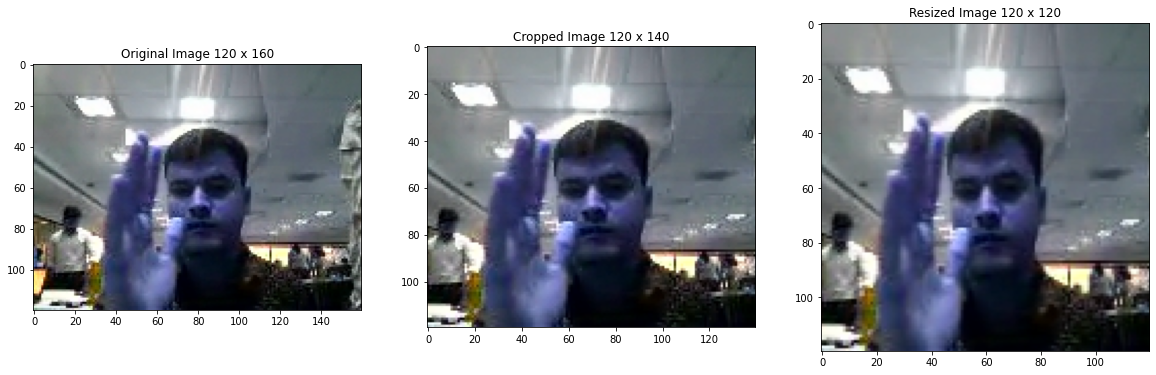

In [ ]:
imgColour = cv2.imread('Project_data/train/WIN_20180926_18_07_05_Pro_Right_Swipe_new/WIN_20180926_18_07_05_Pro_00065.png')
imgColourCopy = imgColour
y = 120 # image width
z = 120 # image height
#Function to crop and resize the image to 12x120
def crop_resize_image(img):
    if img.shape[0] != img.shape[1]:
        img=img[0:120,10:150]
    resized_image = skimage.transform.resize(img, (z,y,3))
    return resized_image

#Crop and Resize the original image
if imgColour.shape[0] != imgColour.shape[1]:
        imgColour=imgColour[0:120,10:150]
resized_image = skimage.transform.resize(imgColour, (z,y,3))
    
#Plotting all for sample
f, axarr = plt.subplots(1,3, squeeze=False, figsize=(20, 10))
axarr[0,0].imshow(imgColourCopy)
axarr[0,0].set_title('Original Image %d x %d' %(imgColourCopy.shape[0], imgColourCopy.shape[1]))

axarr[0,1].imshow(imgColour)
axarr[0,1].set_title('Cropped Image %d x %d' %(imgColour.shape[0], imgColour.shape[1]))

axarr[0,2].imshow(resized_image)
axarr[0,2].set_title('Resized Image %d x %d' %(resized_image.shape[0], resized_image.shape[1]))

In [ ]:
#Considering frame numbers 1 to 30
index_images = [x for x in range(1,30,1)]
x = len(index_images) #number of frames
y = 120 # image width
z = 120 # image height

In [ ]:
# function to plot the training/validation accuracies/losses.
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

# Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
def generator(source_path, folder_list, batch_size, is_train = False, debug=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = index_images #create a list of image numbers you want to use for a particular video [can use bigger batch size]
    while True:
        t = np.random.permutation(folder_list)
        #num_batches = # calculate the number of batches

        if (len(t)%batch_size) == 0:
            num_batches = int(len(t)/batch_size)
        else:
            num_batches = len(t)//batch_size + 1
            
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                folder_idx = folder + (batch*batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                imgs = os.listdir(source_path+'/'+ folder_str.split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = skimage.io.imread(source_path+'/'+ folder_str.strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                        
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    #Crop and Resize the original image
                    resized_image=crop_resize_image(image)
                        
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                if (not is_train):
                    batch_data_final=batch_data
                    batch_label_final= batch_labels
        
            yield batch_data, batch_labels
            
        # write the code for the remaining data points which are left after full batches
        if((len(source_path)%batch_size)//2==0):
            batch_size = 2
        else:
            batch_size = 1
        num_batches = len(source_path)%batch_size # calculate the number of batches
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                folder_idx = folder + (batch*batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                imgs = os.listdir(source_path+'/'+ folder_str.split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = skimage.io.imread(source_path+'/'+ folder_str.strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    #Crop and Resize the original image
                    resized_image=crop_resize_image(image)
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                if (not is_train):
                    batch_data_final=batch_data
                    batch_label_final= batch_labels
        
        
        
        
            yield batch_data, batch_labels 

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


# Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import ConvLSTM2D, Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, GlobalAveragePooling3D, GlobalAveragePooling2D
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
#from keras.optimizers import Adam
import tensorflow 
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

In [ ]:
#Setting train and validation paths in variable
train_path = 'Project_data/train'
val_path = 'Project_data/val'

In [ ]:
#write your model here
channels=3
filtersize=(3,3,3)
input_shape=(x,z,y,channels)
num_classes=5

model1 = Sequential()
model1.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=input_shape))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model1.add(Conv3D(32, (2, 2, 2), padding='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model1.add(Conv3D(64, (2, 2, 2), padding='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model1.add(Conv3D(128, (2, 2, 2), padding='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model1.add(Flatten())
model1.add(Dense(128,activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))

model1.add(Dense(64,activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.25))

model1.add(Dense(num_classes,activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = Adam(0.001) #write your optimizer
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 29, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 29, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 29, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 14, 60, 60, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 14, 60, 60, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 14, 60, 60, 32)    0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

### Model 1 - Base Model - Batch Size 40 and Epoch 15 

In [ ]:
batch_size = 40
num_epochs = 15

curr_dt_time = datetime.datetime.now()

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history1 = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 40
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.5816 - categorical_accuracy: 0.3853  Source path =  Project_data/val ; batch size = 40

Epoch 1: saving model to model_init_2022-03-2921_39_02.921677/model-00001-1.58159-0.38529-2.00028-0.13333.h5
17/17 [==============================] - 1330s 78s/step - loss: 1.5816 - categorical_accuracy: 0.3853 - val_loss: 2.0003 - val_categorical_accuracy: 0.1333 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 1.5966 - categorical_accuracy: 0.2941
Epoch 2: saving model to model_init_2022-03-2921_39_02.921677/model-00002-1.59658-0.29412-3.65720-0.33333.h5
17/17 [==============================] - 37s 2s/step - loss: 1.5966 - categorical_accuracy: 0.2941 - val_loss: 3.6572 - val_categorical_accuracy: 0.3333 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 1.6004 - categorical_accuracy: 0.1176
Epoch 3: saving model to 

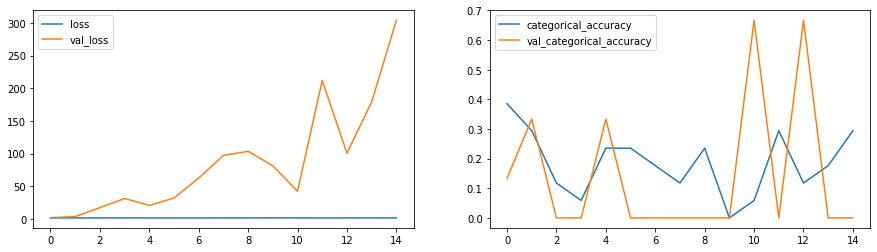

In [ ]:
plot(history1)

### Observation
- From the above graphs, we observed that the validation loss keeps increasing while training loss is almost unchanged.
- We also noticed that model accuracy is about 33%, Let us do some more experiments with the Batch size and epochs.

### Model 2 - Base Model - Batch Size 30 and Epoch 15  

In [ ]:
batch_size = 30
num_epochs = 15

curr_dt_time = datetime.datetime.now()

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)


train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

# training sequences = 663
# validation sequences = 100
# epochs = 15


In [ ]:
history2 = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 30
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 1.2521 - categorical_accuracy: 0.5116 Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-03-2922_10_42.726160/model-00001-1.25212-0.51159-17.36669-0.14167.h5
23/23 [==============================] - 1363s 59s/step - loss: 1.2521 - categorical_accuracy: 0.5116 - val_loss: 17.3667 - val_categorical_accuracy: 0.1417 - lr: 0.0010
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 1.6318 - categorical_accuracy: 0.1304
Epoch 2: saving model to model_init_2022-03-2922_10_42.726160/model-00002-1.63181-0.13043-51.40678-0.00000.h5
23/23 [==============================] - 54s 2s/step - loss: 1.6318 - categorical_accuracy: 0.1304 - val_loss: 51.4068 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/15
23/23 [==============================] - ETA: 0s - loss: 1.6155 - categorical_accuracy: 0.1739
Epoch 3: saving mo

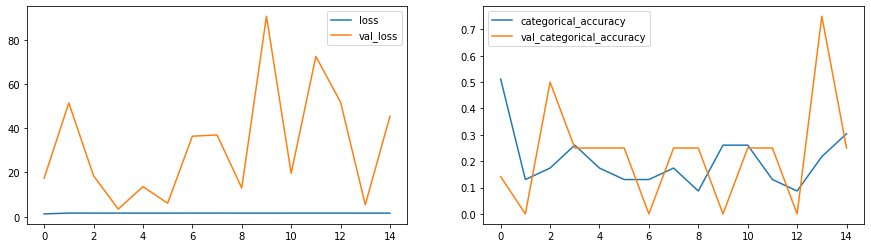

In [ ]:
plot(history2)

### Observation
- From above graphs, we observed that the validation loss changes, but training loss is almost unchanged.
- We also noticed that the model val accuracy is oscillating between 0 and 70%, and thus this does not appear to be a good or stable model. Let us further reduce the batch size.

### Model 3 - Base Model - Batch Size 20 and Epoch 15   

In [ ]:
batch_size = 20
num_epochs = 15

curr_dt_time = datetime.datetime.now()

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)


train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

# training sequences = 663
# validation sequences = 100
# epochs = 15


In [ ]:
history3 = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 20
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.2957 - categorical_accuracy: 0.4162 Source path =  Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2022-03-2922_46_17.117315/model-00001-1.29566-0.41618-19.82079-0.23000.h5
34/34 [==============================] - 1329s 39s/step - loss: 1.2957 - categorical_accuracy: 0.4162 - val_loss: 19.8208 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.6224 - categorical_accuracy: 0.0882
Epoch 2: saving model to model_init_2022-03-2922_46_17.117315/model-00002-1.62242-0.08824-53.09664-0.20000.h5
34/34 [==============================] - 81s 2s/step - loss: 1.6224 - categorical_accuracy: 0.0882 - val_loss: 53.0966 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 1.6129 - categorical_accuracy: 0.2059
Epoch 3: saving model 

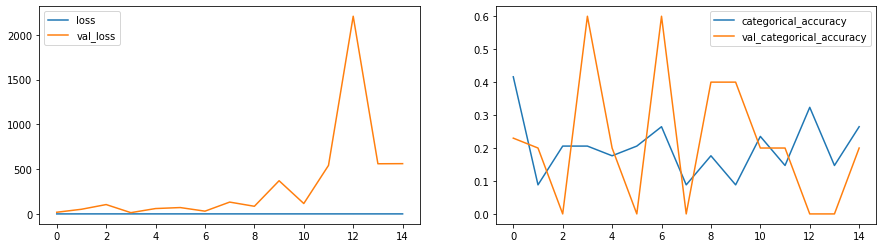

In [ ]:
plot(history3)

### Observation:
- From the above graphs, we observed that the validation loss changes but training loss is almost unchanged.
- We also noticed that the train and val accuracy are far apart, and val accuracy seems to fluctuate a lot, this does not appear to be a good or stable model. Let us continue further.

### Model 4 - Reduce filter size to (2,2,2), Batch size 30 and Epoch 15

In [ ]:
input_shape=(x,z,y,channels)
num_classes=5

model2 = Sequential()
model2.add(Conv3D(16, (2, 2, 2), padding='same', input_shape=input_shape))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(32, (2, 2, 2), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(64, (2, 2, 2), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(128, (2, 2, 2), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Flatten())
model2.add(Dense(128,activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

model2.add(Dense(64,activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))

model2.add(Dense(num_classes,activation='softmax'))

In [ ]:
#from keras.optimizers import Adam

optimiser = Adam(0.001) #write your optimizer
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 29, 120, 120, 16)  400       
                                                                 
 activation_4 (Activation)   (None, 29, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 29, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 14, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 14, 60, 60, 32)    4128      
                                                                 
 activation_5 (Activation)   (None, 14, 60, 60, 32)   

In [ ]:
batch_size = 30

curr_dt_time = datetime.datetime.now()

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)


train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

# training sequences = 663
# validation sequences = 100
# epochs = 15


In [ ]:
history4 = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 30
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 1.5834 - categorical_accuracy: 0.3986 Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-03-2923_27_07.551889/model-00001-1.58344-0.39855-1.87602-0.13333.h5
23/23 [==============================] - 1166s 51s/step - loss: 1.5834 - categorical_accuracy: 0.3986 - val_loss: 1.8760 - val_categorical_accuracy: 0.1333 - lr: 0.0010
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 1.6161 - categorical_accuracy: 0.1739
Epoch 2: saving model to model_init_2022-03-2923_27_07.551889/model-00002-1.61608-0.17391-6.56409-0.25000.h5
23/23 [==============================] - 49s 2s/step - loss: 1.6161 - categorical_accuracy: 0.1739 - val_loss: 6.5641 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/15
23/23 [==============================] - ETA: 0s - loss: 1.6298 - categorical_accuracy: 0.0870
Epoch 3: saving model to m

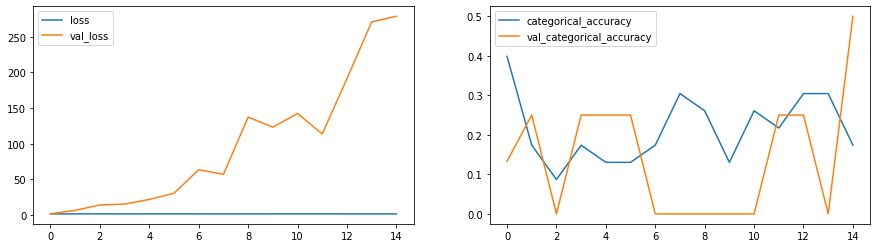

In [ ]:
plot(history4)

### Observation:
- From the above graphs, we observed that the validation loss changes but training loss is almost unchanged.
- We also noticed that train and val accuracy have a huge gap, while val accuracy seems to fluctuate.Val Accuracy seems to vary between 0 and 40%, This does not appear to be a good model. Let us continue further by adding more layers to the model.

### Model 5 - Adding more layers 

In [ ]:
channels=3
input_shape=(x,y,z,channels)
model3 = Sequential()
model3.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=input_shape, padding='same'))
model3.add(Activation('relu'))
# model_b.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
# model_b.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
#model_b.add(Dropout(0.25))

model3.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model3.add(Activation('relu'))
# model_b.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
# model_b.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
#model_b.add(Dropout(0.25))

model3.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
#model_b.add(Dropout(0.25))

model3.add(Conv3D(256, kernel_size=(3, 3, 3), padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
#model_b.add(Dropout(0.5))

model3.add(Conv3D(512, kernel_size=(3, 3, 3), padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
#model_b.add(Dropout(0.5))

model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(5, activation='softmax'))

# model_b.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model_b.summary()

In [ ]:
optimiser = Adam(0.001) #write your optimizer
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 29, 120, 120, 32)  2624      
                                                                 
 activation_8 (Activation)   (None, 29, 120, 120, 32)  0         
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 40, 40, 32)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 40, 40, 64)    55360     
                                                                 
 activation_9 (Activation)   (None, 10, 40, 40, 64)    0         
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 4, 14, 14, 64)    0         
 3D)                                                  

In [ ]:
batch_size = 30

curr_dt_time = datetime.datetime.now()

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)


train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

# training sequences = 663
# validation sequences = 100
# epochs = 15


In [ ]:
history5 = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 30
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 1.5558 - categorical_accuracy: 0.1971  Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-03-2923_57_25.600496/model-00001-1.55581-0.19710-1.32737-0.35000.h5
23/23 [==============================] - 1825s 79s/step - loss: 1.5558 - categorical_accuracy: 0.1971 - val_loss: 1.3274 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 1.7783 - categorical_accuracy: 0.3043
Epoch 2: saving model to model_init_2022-03-2923_57_25.600496/model-00002-1.77833-0.30435-1.60052-0.50000.h5
23/23 [==============================] - 67s 3s/step - loss: 1.7783 - categorical_accuracy: 0.3043 - val_loss: 1.6005 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 3/15
23/23 [==============================] - ETA: 0s - loss: 1.6140 - categorical_accuracy: 0.2174
Epoch 3: saving model to 

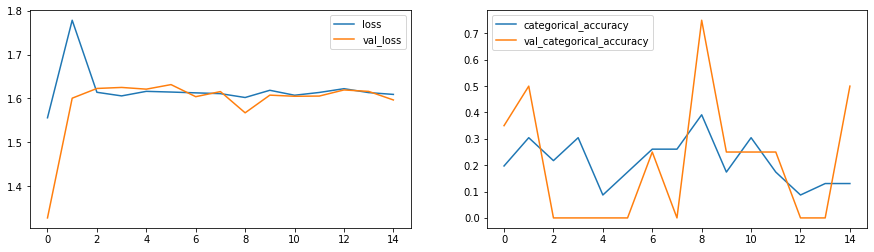

In [ ]:
plot(history5)

### Observation:
From above graphs:
- We observed that the validation loss and training loss both are almost unchanged. 
- We also noticed that train and val accuracy still are not similar, and val accuracy seems to fluctuate. Val accuracy seems to vary between 0 and 70%, this does not appear to be a good or stable model. Let us continue further by adding dropouts.

### Model 6 - Adding dropout at convolution layers  

In [ ]:
channels=3
input_shape=(x,y,z,channels)
model4 = Sequential()
model4.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=input_shape, padding='same'))
model4.add(Activation('relu'))
# model_b.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
# model_b.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model4.add(Dropout(0.25))

model4.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model4.add(Activation('relu'))
# model_b.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
# model_b.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model4.add(Dropout(0.25))

model4.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model4.add(Dropout(0.25))

model4.add(Conv3D(256, kernel_size=(3, 3, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model4.add(Dropout(0.25))

model4.add(Conv3D(512, kernel_size=(3, 3, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model4.add(Dropout(0.5))

model4.add(Flatten())
model4.add(Dense(512, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(5, activation='softmax'))

# model_b.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model_b.summary()

In [ ]:
optimiser = Adam(0.001) #write your optimizer
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_13 (Conv3D)          (None, 29, 120, 120, 32)  2624      
                                                                 
 activation_13 (Activation)  (None, 29, 120, 120, 32)  0         
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 10, 40, 40, 32)   0         
 g3D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 10, 40, 40, 32)    0         
                                                                 
 conv3d_14 (Conv3D)          (None, 10, 40, 40, 64)    55360     
                                                                 
 activation_14 (Activation)  (None, 10, 40, 40, 64)    0         
                                                      

In [ ]:
batch_size = 30

curr_dt_time = datetime.datetime.now()

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [ ]:
history6 = model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.5583 - categorical_accuracy: 0.1812  Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-03-3000_43_51.495645/model-00001-1.55826-0.18116-1.33887-0.17500.h5
23/23 [==============================] - 1832s 80s/step - loss: 1.5583 - categorical_accuracy: 0.1812 - val_loss: 1.3389 - val_categorical_accuracy: 0.1750 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.6345 - categorical_accuracy: 0.2609
Epoch 2: saving model to model_init_2022-03-3000_43_51.495645/model-00002-1.63447-0.26087-1.59675-0.50000.h5
23/23 [==============================] - 69s 3s/step - loss: 1.6345 - categorical_accuracy: 0.2609 - val_loss: 1.5967 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.6256 - categorical_accuracy: 0.1304
Epoch 3: saving model to 

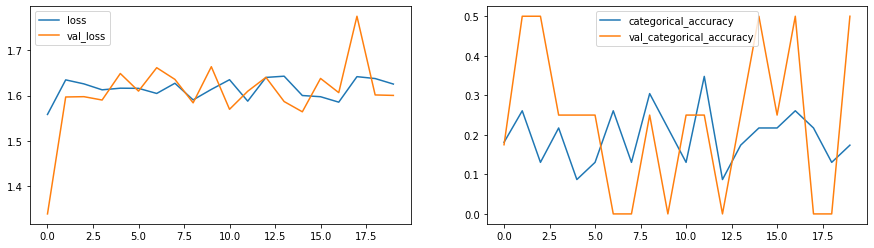

In [ ]:
plot(history6)

### Observation:
- We still see the similar trend as before, i.e. train and val loss are reducing very slowly and accuracies are fluctuating and still in the range of 0-50%, let's try to change the optimizer.

### Model 7 -  Change Optimizer to Adadelta Experiment

In [ ]:
#from keras.optimizers import Adadelta
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adadelta

optimiser = Adadelta(0.001) #write your optimizer
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_13 (Conv3D)          (None, 29, 120, 120, 32)  2624      
                                                                 
 activation_13 (Activation)  (None, 29, 120, 120, 32)  0         
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 10, 40, 40, 32)   0         
 g3D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 10, 40, 40, 32)    0         
                                                                 
 conv3d_14 (Conv3D)          (None, 10, 40, 40, 64)    55360     
                                                                 
 activation_14 (Activation)  (None, 10, 40, 40, 64)    0         
                                                      

In [ ]:
batch_size = 30

curr_dt_time = datetime.datetime.now()

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [ ]:
history7 = model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.5479 - categorical_accuracy: 0.1913  Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-03-3001_36_25.757437/model-00001-1.54787-0.19130-1.33740-0.19167.h5
23/23 [==============================] - 1832s 80s/step - loss: 1.5479 - categorical_accuracy: 0.1913 - val_loss: 1.3374 - val_categorical_accuracy: 0.1917 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.6049 - categorical_accuracy: 0.2609
Epoch 2: saving model to model_init_2022-03-3001_36_25.757437/model-00002-1.60489-0.26087-1.59471-0.25000.h5
23/23 [==============================] - 66s 3s/step - loss: 1.6049 - categorical_accuracy: 0.2609 - val_loss: 1.5947 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.6158 - categorical_accuracy: 0.1304
Epoch 3: saving model to 

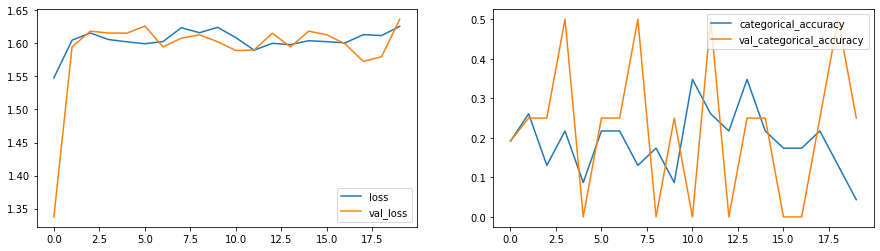

In [ ]:
plot(history7)

### Observation:
- The above experiments are also not satisfactory as we see similar trends as before. Let us consider TimeDistributed architecture

### Model 8 - TimeDistributed Conv2D + GRU 

In [ ]:
channels=3
input_shape=(x,y,z,channels)
model5 = Sequential()

model5.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

model5.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

model5.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

model5.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

model5.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

# #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
#  model.add(TimeDistributed(BatchNormalization()))
#  model.add(TimeDistributed(MaxPooling2D((2, 2))))

model5.add(TimeDistributed(Flatten()))


model5.add(LSTM(64))
model5.add(Dropout(0.25))

model5.add(Dense(64,activation='relu'))
model5.add(Dropout(0.25))

model5.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = Adam(0.001) #write your optimizer
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 29, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 29, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 29, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 29, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 29, 60, 60, 32)  

In [ ]:
batch_size = 30

curr_dt_time = datetime.datetime.now()

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [ ]:
history8 = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.4850 - categorical_accuracy: 0.2884 Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-03-3002_28_59.660121/model-00001-1.48497-0.28841-1.42937-0.19167.h5
23/23 [==============================] - 788s 34s/step - loss: 1.4850 - categorical_accuracy: 0.2884 - val_loss: 1.4294 - val_categorical_accuracy: 0.1917 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.7420 - categorical_accuracy: 0.0870
Epoch 2: saving model to model_init_2022-03-3002_28_59.660121/model-00002-1.74200-0.08696-1.80067-0.00000.h5
23/23 [==============================] - 31s 1s/step - loss: 1.7420 - categorical_accuracy: 0.0870 - val_loss: 1.8007 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.7593 - categorical_accuracy: 0.0870
Epoch 3: saving model t

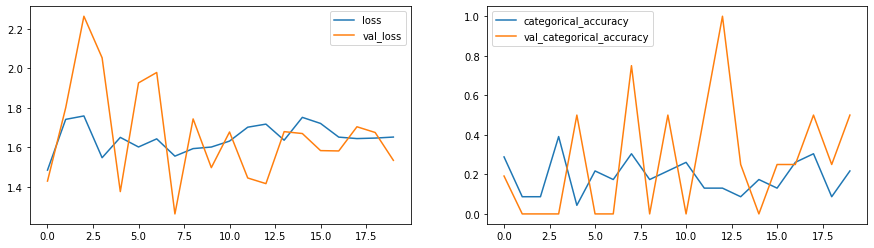

In [ ]:
plot(history8)

### Observation:
We can see minor improvement now. The loss values are slowly coming down while the accuracies are still around 30%, let us add more dense layers to the architecture and see.

### Model 9 - TimeDistributed Conv2D + Dense Layer

In [ ]:
channels=3
input_shape=(x,y,z,channels)
model6 = Sequential()

model6 = Sequential()
model6.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
model6.add(TimeDistributed(MaxPooling2D((2,2))))
model6.add(BatchNormalization())

model6.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model6.add(TimeDistributed(MaxPooling2D((2,2))))
model6.add(BatchNormalization())

model6.add(TimeDistributed(Conv2D(128, (3,3), activation='relu')))
model6.add(TimeDistributed(MaxPooling2D((2,2))))
model6.add(BatchNormalization())

model6.add(GlobalAveragePooling3D())
model6.add(Dense(256, activation='relu'))
model6.add(BatchNormalization())
model6.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = Adam(0.001) #write your optimizer
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model6.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 29, 118, 118, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 29, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization (BatchN  (None, 29, 59, 59, 32)   128       
 ormalization)                                                   
                                                                 
 time_distributed_2 (TimeDis  (None, 29, 57, 57, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 29, 28, 28, 64)  

In [ ]:
batch_size = 30

curr_dt_time = datetime.datetime.now()

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)


train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

In [ ]:
history9 = model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 30
Epoch 1/20


In [ ]:
plot(history9)

### Observation:
We see slight improvement wherein the accuracies are slowly improving around 30% although the loss decrease is not very significant, Let us try ConvLSTM2D now

### Model 10 - TimeDistributed + ConvLSTM2D 

In [ ]:
channels=3
input_shape=(x,y,z,channels)
nb_featuremap = [8,16,32,64]
nb_dense = [128,64,5]
nb_classes = 5
# Input
#input_shape=(frames,rows,cols,channel)

model7 = Sequential()

model7.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))


model7.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
model7.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model7.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
model7.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model7.add(TimeDistributed(Conv2D(nb_featuremap[3], (2,2),padding='same', activation='relu')))
model7.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model7.add(TimeDistributed(BatchNormalization()))
model7.add(Dropout(0.25))

model7.add(TimeDistributed(Flatten()))

model7.add(Dense(nb_dense[0], activation='relu'))
model7.add(Dropout(0.25))
model7.add(Dense(nb_dense[1], activation='relu'))
model7.add(Dropout(0.25))

## using GRU as the RNN model along with softmax as our last layer.
model7.add(GRU(128, return_sequences=False))
model7.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer


In [ ]:
optimiser = Adam(0.001) #write your optimizer
model7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model7.summary())

In [ ]:
batch_size = 30

curr_dt_time = datetime.datetime.now()

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)


train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

In [ ]:
history10 = model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(history10)

### Observation:
- We see that loss values are steadily decreasing over time
- We also see that accuracy is increasing overall to around 50-60%
- This is a good indication that the current model is better than the earlier models.
- We can perform various experiements with this model ahead.

## Final Model - Model 11 - TimeDistributed + ConvLSTM2D with specific hyper parameters

In [ ]:
channels=3
input_shape=(x,y,z,channels)
nb_featuremap = [8,16,32,64]
nb_dense = [128,64,5]
nb_classes = 5
# Input
#input_shape=(frames,rows,cols,channel)

model11 = Sequential()

model11.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))

model11.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
model11.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model11.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
model11.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model11.add(TimeDistributed(Conv2D(nb_featuremap[3], (2,2),padding='same', activation='relu')))
model11.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model11.add(TimeDistributed(BatchNormalization()))
model11.add(Dropout(0.25))

model11.add(TimeDistributed(Flatten()))

model11.add(Dense(nb_dense[0], activation='relu'))
model11.add(Dropout(0.25))
model11.add(Dense(nb_dense[1], activation='relu'))
model11.add(Dropout(0.25))

## using GRU as the RNN model along with softmax as our last layer.
model11.add(GRU(128, return_sequences=False))
model11.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer

optimiser = Adam(0.001) #write your optimizer
model11.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model11.summary())

In [ ]:
batch_size = 30

curr_dt_time = datetime.datetime.now()

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)


train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history11 = model11.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(history11)

### Observations:
**We performed several experiments using this model and changing the hyper parameters. The hyper parameters are mentioned below:**
- batch_size= 20, 30, 40
- epochs=15,20
- adam_optimizer=0.001
- ReduceLROnPlateau_factor=0.2
- ReduceLROnPlateau_patience=2, 5
- ReduceLROnPlateau_min_lr=0.001, 0.0001

**About 20+ models were trained and evaluated. Since it is not possible to include all those results, we are 
showing the model which gave the best results using these parameters
The following parameter combinations gave the best result and thus presented as the final model**
- batch_size= 30
- epochs=50
- adam_optimizer=0.001
- ReduceLROnPlateau_factor=0.2
- ReduceLROnPlateau_patience=2
- ReduceLROnPlateau_min_lr=0.0001

### Conclusion:
- From the above, we observe that the loss decreases steadily till around epoch 47. After that, val loss shoots up.
- We also notice that overall accuracy is good at the range of epoch 47.
- On seeing the logs and comparing, we find that at epoch 47 **loss: 0.5830 - categorical_accuracy: 0.8696 - val_loss: 0.4577 - val_categorical_accuracy: 0.8750 - lr: 1.0000e-04**

- Hence, the best model file in the current situation is **model-00047-0.58303-0.86957-0.45769-0.87500.h5**